In [14]:
!pip install rasterio
from matplotlib import colors
import math
import rasterio
import matplotlib.pyplot as plt
import numpy

Minimum value of NDVI obtained: -0.1797752808988764
Maximum value of NDVI obtained: 0.65


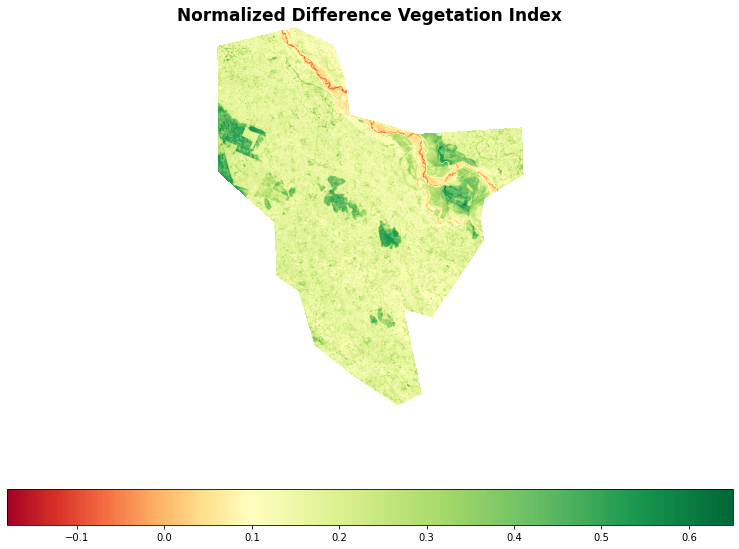

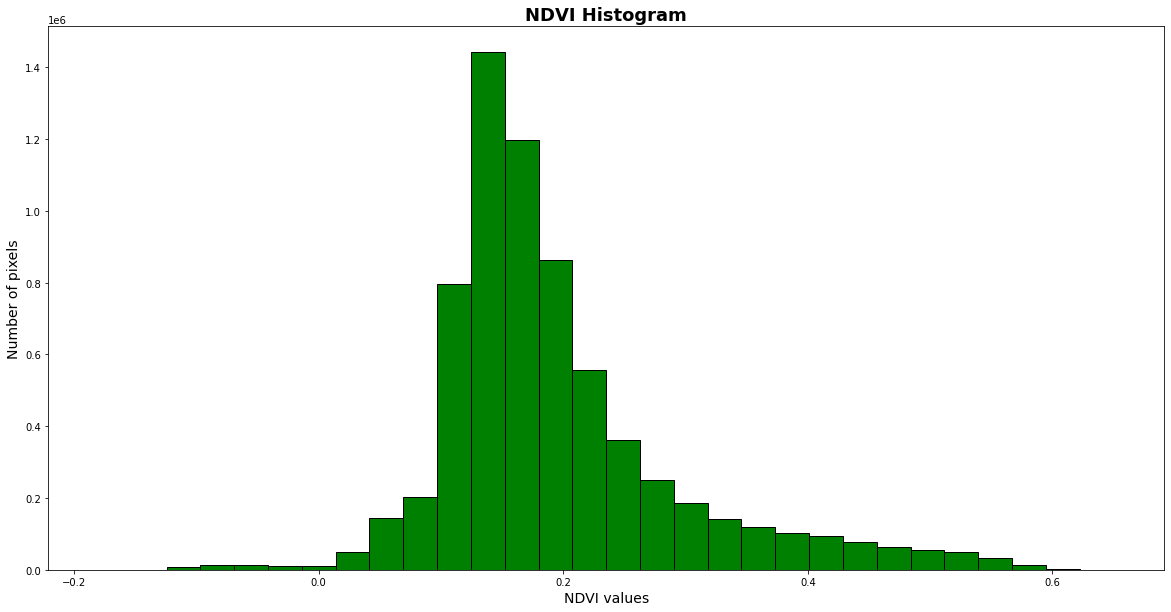

In [15]:
def agriculture(a):
  image_file = a
  sat_data = rasterio.open(image_file)

  # getting dimentions in m
  width_in_projected_units = sat_data.bounds.right - sat_data.bounds.left
  height_in_projected_units = sat_data.bounds.top - sat_data.bounds.bottom
  
  # Upper left pixel
  row_min = 0
  col_min = 0

  # Lower right pixel.  Rows and columns are zero indexing.
  row_max = sat_data.height - 1
  col_max = sat_data.width - 1

  # Transform coordinates with the dataset's affine transformation.
  topleft = sat_data.transform * (row_min, col_min)
  botright = sat_data.transform * (row_max, col_max)


  # sequence of band indexes, we have taken a 4 band image 1:R,2:B,3:G,4:IR

  filename =a
  with rasterio.open(filename) as src:
      band_red = src.read(3)
  with rasterio.open(filename) as src:
      band_nir = src.read(4)

  #To not display error when divided by zero 

  numpy.seterr(divide='ignore', invalid='ignore')

  # NDVI convertion
  ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

  print("Minimum value of NDVI obtained:",numpy.nanmin(ndvi)) 
  print("Maximum value of NDVI obtained:",numpy.nanmax(ndvi))

  # get the metadata of original GeoTIFF:
  meta = src.meta
  
  # get the dtype of our NDVI array:
  ndvi_dtype = ndvi.dtype
  
  # set the source metadata as kwargs we'll use to write the new data:
  kwargs = meta

  # update the 'dtype' value to match our NDVI array's dtype:
  kwargs.update(dtype=ndvi_dtype)

  # update the 'count' value since our output will no longer be a 4-band image:
  kwargs.update(count=1)

  # using rasterio to write new raster file 'data/ndvi.tif':
  with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
          dst.write(ndvi, 1)
  # colour coding the NVDI image for better understanding
  class MidpointNormalize(colors.Normalize):
    
      def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
          self.midpoint = midpoint
          colors.Normalize.__init__(self, vmin, vmax, clip)

      def __call__(self, value, clip=None):
        
          x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
          return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

  # Set min/max values from NDVI range for image
  
  min=numpy.nanmin(ndvi)
  max=numpy.nanmax(ndvi)

  # Set custom midpoint for most effective NDVI analysis
  mid=0.1

  # Setting color scheme
  colormap = plt.cm.RdYlGn 
  norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
  fig = plt.figure(figsize=(20,10))


  ax = fig.add_subplot(111)

  # Using 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
  cbar_plot = ax.imshow(ndvi, cmap=colormap, vmin=min, vmax=max, norm=norm)


  # Turning off the display of axis labels 
  ax.axis('off')

  # Seeing a title 
  ax.set_title('Normalized Difference Vegetation Index', fontsize=17, fontweight='bold')

  # Configuring the colorbar
  cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

  # Calling 'savefig' to save plot to an image file
  fig.savefig("ndvi-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

  # visualizing
  plt.show()

  # Define a new figure
  fig2 = plt.figure(figsize=(20,10))

  # Give this new figure a subplot, which will contain the histogram itself
  ax = fig2.add_subplot(111)

  # Add a title & (x,y) labels to the plot
  plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
  plt.xlabel("NDVI values", fontsize=14)
  plt.ylabel("Number of pixels", fontsize=14)


  # For the x-axis, we want to count every pixel that is not an empty value
  x = ndvi[~numpy.isnan(ndvi)]
  color = 'g'
  # call 'hist` with our x-axis, bins, and color details
  ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

  # Save the generated figure to an external image file
  #fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)

  plt.show()

agriculture("/content/sample_data/15 november 2021.tif")

